In [ ]:
# A quick script to compare the detrended and isochrone output of SM-emp on the
# calibration dataset to Gaia and the Yee library.

In [40]:
# compare SMP derived values to Gaia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia

gaia_values = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/gaia_values.csv')
apf_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_stellar_properties/all_apf/specmatch_results_all_apf.csv') # SM-Emp values derived from APF spectra
#apf_data_detrended = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_detrended.csv') # SM-Emp values derived from APF spectra, detrended in run_smemp_apf.ipynb
hires_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/lincomb_results_detrend.csv') # SM-Emp values derived from HIRES spectra (detrended)
yee_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/yee_library_full.csv') # library values

In [41]:
def get_names(sim_name):
    # get Gaia and 2MASS names (for creating flags and for later isochrone analysis)
    result_table = Simbad.query_objectids(sim_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name
    return gaia_source_id, id_2MASS

def query_gaia_data(gaia_source_id):
    # Gaia properties to flag stars outside library bounds
    #gaia_data =  pd.read_csv('./Gaia_properties_by_HIP_name.csv') # gaia stellar properties (only R and Teff)
    query1 = "SELECT source_id, ra, dec, parallax, parallax_error, teff_val, radius_val  FROM gaiadr2.gaia_source WHERE source_id = " + str(gaia_source_id)
    job = Gaia.launch_job(query1)
    gaia_data = job.get_results()
    return gaia_data

In [31]:
len(np.where(apf_data['failure_code'] == 0)[0])

774

In [ ]:
# how many are cut by which cuts

no_iod = apf_data['iodine_flag'] == 0
iod = apf_data['iodine_flag'] == 1
binary = apf_data['binary_flag'] == 1
not_star = apf_data['non-stellar_flag'] == 1
no_SM_fail = apf_data['failure_code'] == 0
fail = apf_data['failure_code'] == 1
no_iso_fail = (apf_data['iso_fail_flag'] == 0) * (apf_data['iso_Teff'] > 0)
iso_fail = (apf_data['iso_fail_flag'] == 1) | (apf_data['iso_Teff'] == 0)
in_bounds = (apf_data['Teff_bounds_flag'] == 0)*(apf_data['R_bounds_flag'] == 0)
nan_parallax = 'Nan parallax' in str(apf_data['warnings'])
no_gaia_name = 'Failed to find Gaia' in str(apf_data['warnings']) * (not 'Failed to find 2MASS' in str(apf_data['warnings']))
no_2MASS_name = 'Failed to find 2MASS' in str(apf_data['warnings']) * (not 'Failed to find Gaia' in str(apf_data['warnings']))
no_both_names = 'Failed to find 2MASS' in str(apf_data['warnings']) * 'Failed to find Gaia' in str(apf_data['warnings'])

total_stars = len(apf_data)
no_iodine = len(np.where(no_iod)[0])
iod = len(np.where(iod)[0])
no_SM_fail = len(np.where([no_SM_fail])[0])
SM_fail = len(np.where([fail])[0])
no_iso_fail = len(np.where([no_iso_fail])[0])
iso_fail = len(np.where([iso_fail])[0])
in_bounds = len(np.where([in_bounds])[0])
nan_parallax = len(np.where([nan_parallax])[0])
no_gaia_name = len(np.where([no_gaia_name])[0])
no_2MASS_name = len(np.where([no_2MASS_name])[0])
no_both_names = len(np.where([no_both_names])[0])
no_iod_no_SM_fail_no_iso_fail = len(np.where([no_iod*no_SM_fail*no_iso_fail])[0])
no_iod_no_SM_fail_no_iso_fail_in_bounds = len(np.where([no_iod*no_SM_fail*no_iso_fail*in_bounds])[0])
use_stars = no_iod*no_SM_fail*no_iso_fail*in_bounds #np.invert(np.isnan(apf_data['iso_Teff'])) * (apf_data['iso_Teff'] > 0) # or maybe should use non iso value in this case
starlist = apf_data[use_stars]['Simbad_resolvable_name'] # list of stars with isochrone values


print('TOTAL TARGET STARS: ' + str(total_stars))
print('   Including  ' + str(len((apf_data['HIP_name'])) - len(set(apf_data['HIP_name']))) + ' repeated stars.')
print('Total sucessful: ' + str(no_SM_fail))
print('Total failed: ' + str(SM_fail))
#print('without iodine: ' + str(no_iodine))
print('     ' + str(iod) + ' becuase spectra/um contains iodine.')
print('     ' + str(binary) + ' becuase is a known binary.')
print('     ' + str(not_star) + ' becuase known to be a non-stellar object.')
print('Total ran with isoclassify: ' + str(no_iso_fail))
print('Total failed isoclassify OR all results zero: ' - str(iso_fail) + '(plus ' + str(SM_fail) + ' failed SM so no attempt at isoclassify)')
print('     ' + str(no_gaia_name) ' becuase no Gaia name found.')
print('     ' + str(no_2MASS_name) ' becuase no 2MASS name found.')
print('     ' + str(no_both_names) ' becuase no Gaia or 2MASS name found.')
print('     ' + str(nan_parallax) ' becuase Gaia parallax returned Nan.')
print('Total within library bounds: ' + str(in_bounds))
print('     with ' + str(no_iod_no_SM_fail_no_iso_fail_in_bounds) ' within bounds and no SM or isoclassify failure.')
print('TOTAL STARS SUCCESSFUL: ' + str(no_iod_no_SM_fail_no_iso_fail_in_bounds))
      
#print('no iodine no SM fail: ' + str(no_iod_no_SM_fail))
#print('no iodine no SM fail no iso fail: ' + str(no_iod_no_SM_fail_no_iso_fail))
#print('no iodine no SM fail no iso fail in bounds: ' + str(no_iod_no_SM_fail_no_iso_fail_in_bounds))

print('')
print('There were ' + str(len((starlist)) - len(set(starlist))) + ' repeated stars in the remaining ' +
      str(no_iod_no_SM_fail_no_iso_fail_in_bounds))

if len((apf_data['Simbad_resolvable_name'])) != len(set(apf_data['Simbad_resolvable_name'])):
    print('')
    print('The fact that there were repeats means the input spectra were not initially grouped by star correctly!')

In [74]:
use_stars = no_iod*no_SM_fail*no_iso_fail*in_bounds #np.invert(np.isnan(apf_data['iso_Teff'])) * (apf_data['iso_Teff'] > 0) # or maybe should use non iso value in this case
starlist = apf_data[use_stars]['Simbad_resolvable_name'] # list of stars with isochrone values
starlist = list(set(starlist)) # remove repeats

# only use stars that have gaia values, and make sure they are in order
apf_results = pd.DataFrame(columns = apf_data.columns)
gaia_data = pd.DataFrame(columns = gaia_values.columns)
for sim_name in starlist:
   # try:
    gaia_source_id, id_2MASS = get_names(sim_name)
    gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
    gaia_row = gaia_row.median(axis = 0, skipna = True)
    
    if np.isnan(np.nanmedian(gaia_row['radius_val'])) or np.isnan(np.nanmedian(gaia_row['teff_val'])):
        print('Skipping ' + sim_name + ', either Teff or R is NaN in Gaia.')
        continue
    #print(len(gaia_data))
    #print(len(apf_results))
    gaia_data = gaia_data.append(gaia_row, ignore_index = True)
    apf_results = apf_results.append(apf_data[apf_data['Simbad_resolvable_name'] == sim_name].iloc[0,:]) # for now to deal w/ repeats only take first row

#except Exception:
    #    print('Skipping ' + HIP_name + ', not found in gaia list.')
        
gaia_Teff_err = 324 # K
gaia_R_err_pcnt = 0.10 # percent!!

/home/azuckerman/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [75]:
len(apf_results)


424

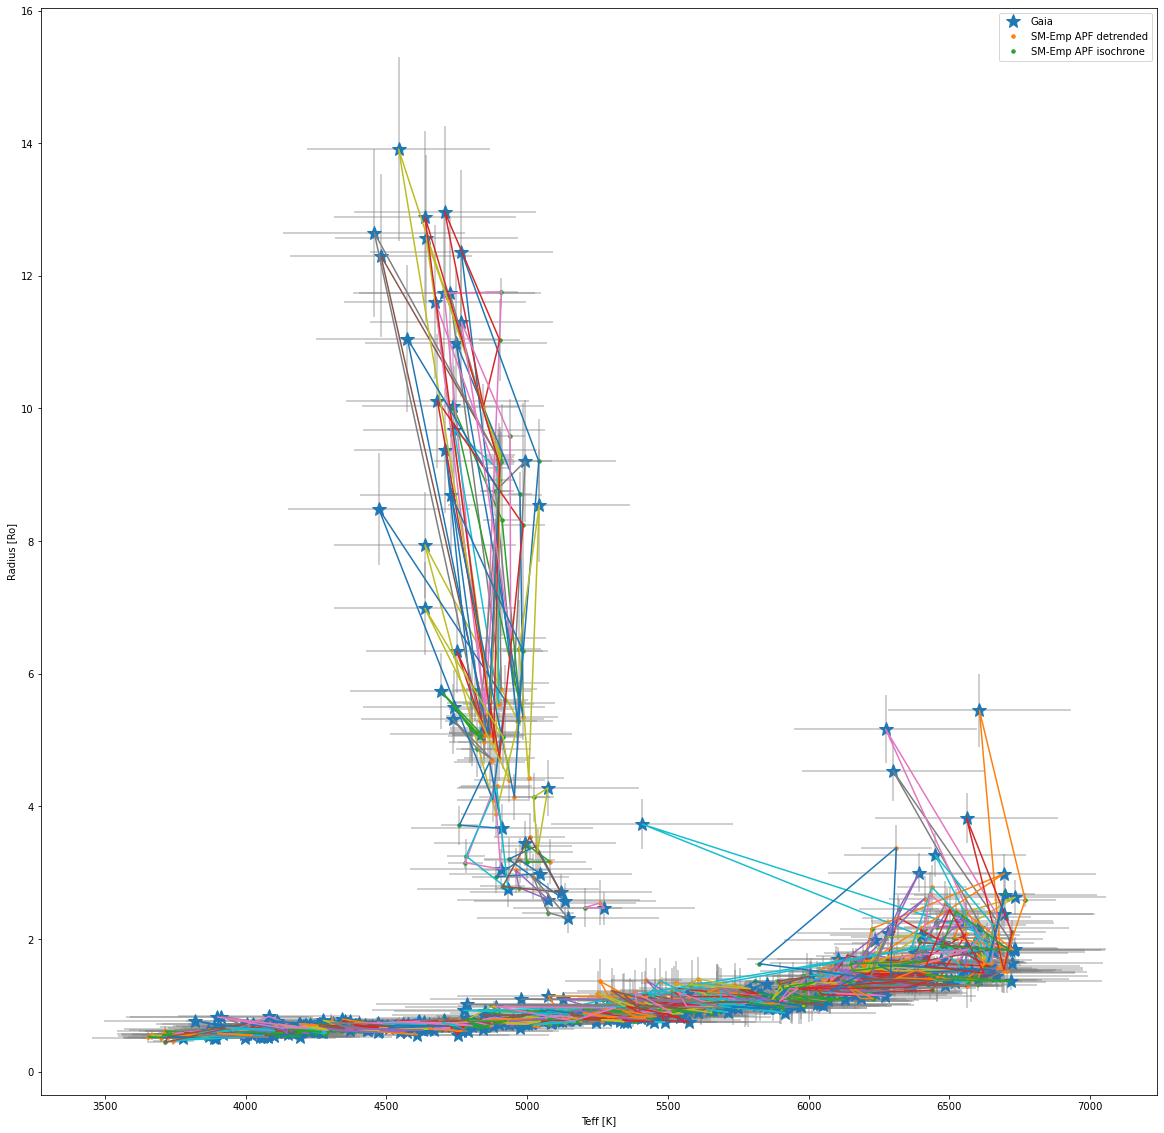

In [76]:
# OUTDATED AS OF 11/5/21!
plt.figure(figsize = [20,20])
#plt.subplot(211)
plt.plot(gaia_data['teff_val'], gaia_data['radius_val'], '*', markersize = 14, label = 'Gaia')
plt.errorbar(gaia_data['teff_val'], gaia_data['radius_val'], xerr = gaia_Teff_err, yerr = gaia_data['radius_val'] * gaia_R_err_pcnt, ls = 'None', color = 'gray', alpha = 0.5)
plt.plot(apf_results['Teff_detrended'], apf_results['radius_detrended'], '.',  markersize = 7, label = 'SM-Emp APF detrended')
plt.errorbar(apf_results['Teff_detrended'], apf_results['radius_detrended'], xerr= apf_results['u_Teff_detrended'], 
             yerr = apf_results['u_radius_detrended'], ls = 'None', color = 'gray', alpha = 0.5)
plt.plot(apf_results['iso_Teff'], apf_results['iso_radius'], '.',  markersize = 7, label = 'SM-Emp APF isochrone')
plt.errorbar(apf_results['iso_Teff'], apf_results['iso_radius'], xerr = [apf_results['iso_um_Teff'], apf_results['iso_um_Teff']],
             yerr = [apf_results['iso_um_radius'], apf_results['iso_um_radius']] , ls = 'None', color = 'gray', alpha = 0.5)
for row in range(len(apf_results)):
    plt.plot([apf_results['iso_Teff'].iloc[row], apf_results['Teff_detrended'].iloc[row], gaia_data['teff_val'].iloc[row], apf_results['iso_Teff'].iloc[row]],
             [apf_results['iso_radius'].iloc[row], apf_results['radius_detrended'].iloc[row], gaia_data['radius_val'].iloc[row], apf_results['iso_radius'].iloc[row]])
plt.xlabel('Teff [K]'); plt.ylabel('Radius [Ro]'); plt.legend()

Teff: 
   Isochrone is better for 223 stars and worse for 195 stars
Radius: 
   Isochrone is better for 306 stars and worse for 109 stars


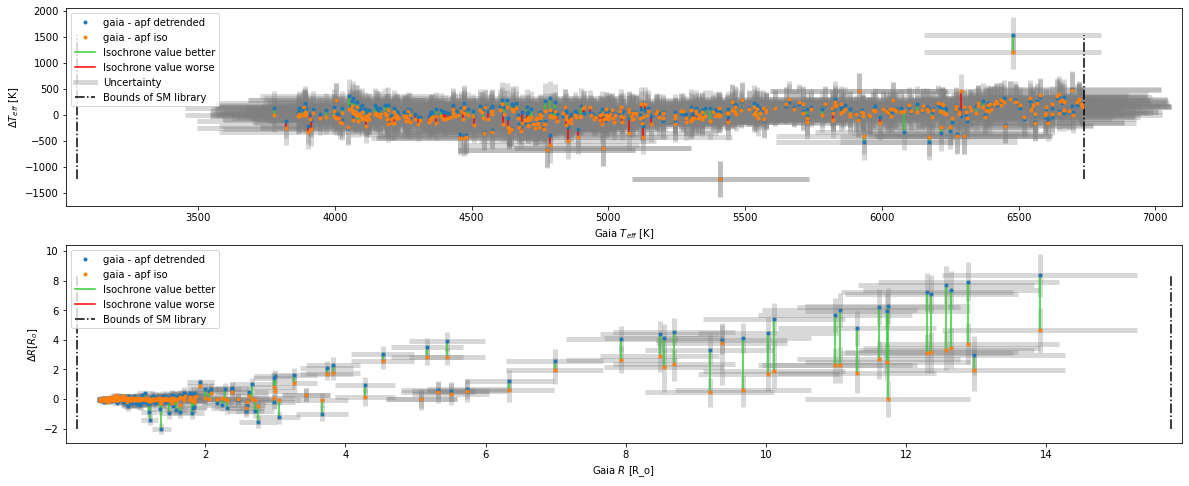

In [77]:
delta_Teff_det = gaia_data['teff_val'].to_numpy() - apf_results['Teff_detrended'].to_numpy()
delta_R_det = gaia_data['radius_val'].to_numpy() - apf_results['radius_detrended'].to_numpy()
delta_Teff_iso = gaia_data['teff_val'].to_numpy() - apf_results['iso_Teff'].to_numpy() 
delta_R_iso = gaia_data['radius_val'].to_numpy() - apf_results['iso_radius'].to_numpy() 

plt.figure(figsize = [20,8])
plt.subplot(211)
good = 0; bad = 0
for row in range(len(apf_results)):
    if abs(delta_Teff_det[row]) > abs(delta_Teff_iso[row]): 
        c = 'limegreen'
        good += 1
    elif abs(delta_Teff_det[row]) < abs(delta_Teff_iso[row]): 
        c = 'red'
        bad += 1
    plt.plot([gaia_data['teff_val'][row],gaia_data['teff_val'][row]], [delta_Teff_det[row], delta_Teff_iso[row]], color = c)
plt.plot(gaia_data['teff_val'], delta_Teff_det, '.', label = 'gaia - apf detrended')
plt.errorbar(gaia_data['teff_val'], delta_Teff_det, yerr = np.sqrt(apf_results['u_Teff_detrended'].to_numpy()**2 + (gaia_Teff_err)**2), xerr = gaia_Teff_err,
             color = 'grey', alpha = 0.3, linewidth = 5, ls = 'None')
plt.plot(gaia_data['teff_val'], delta_Teff_iso, '.', label = 'gaia - apf iso') 
plt.errorbar(gaia_data['teff_val'], delta_Teff_iso, yerr = [np.sqrt(apf_results['iso_up_Teff'].to_numpy()**2 + (gaia_Teff_err)**2), np.sqrt(apf_results['iso_um_Teff'].to_numpy()**2 + (gaia_Teff_err)**2)], xerr = gaia_Teff_err,
             color = 'grey', alpha = 0.3, linewidth = 5, ls = 'None')
plt.vlines([3056, 6738], ymin = np.nanmin(delta_Teff_det), ymax = np.nanmax(delta_Teff_det), ls = '-.',  label = 'Bounds of SM library') 
plt.plot([],[], color = 'limegreen', label = 'Isochrone value better'); plt.plot([],[], color = 'red', label = 'Isochrone value worse'); plt.plot([],[], color = 'grey', alpha = 0.3, linewidth = 5, label = 'Uncertainty') # hack for legend
plt.margins(x=0.01)#plt.xlim([3500, 7500])
#plt.axis('equal')
plt.xlabel('Gaia $T_{eff}$ [K]'); plt.ylabel('$\Delta T_{eff}$ [K]'); plt.legend()
print('Teff: ')
print('   Isochrone is better for ' + str(good) + ' stars and worse for ' + str(bad) + ' stars')

plt.subplot(212)
good = 0; bad = 0
for row in range(len(apf_results)):
    if abs(delta_R_det[row]) > abs(delta_R_iso[row]): 
        c = 'limegreen'
        good += 1
    elif abs(delta_R_det[row]) < abs(delta_R_iso[row]): 
        c = 'red'
        bad += 1
    plt.plot([gaia_data['radius_val'][row],gaia_data['radius_val'][row]], [delta_R_det[row], delta_R_iso[row]], color = c)
plt.plot(gaia_data['radius_val'], delta_R_det, '.', label = 'gaia - apf detrended')
plt.errorbar(gaia_data['radius_val'], delta_R_det, yerr = np.sqrt(apf_results['u_radius_detrended'].to_numpy()**2 + (0.10*gaia_data['radius_val'])**2), xerr = 0.10*gaia_data['radius_val'],
             color = 'grey', alpha = 0.3, linewidth = 5, ls = 'None')
plt.vlines([0.168, 15.781], ymin = np.nanmin(delta_R_det), ymax = np.nanmax(delta_R_det), ls = '-.',  label = 'Bounds of SM library') 
plt.errorbar(gaia_data['radius_val'], delta_R_iso, yerr =[np.sqrt(apf_results['iso_up_radius'].to_numpy()**2 + (0.10*gaia_data['radius_val'])**2), np.sqrt(apf_results['iso_um_radius'].to_numpy()**2 + (0.10*gaia_data['radius_val'])**2)], xerr = 0.10*gaia_data['radius_val'],
             color = 'grey', alpha = 0.3, linewidth = 5, ls = 'None')
plt.plot(gaia_data['radius_val'], delta_R_iso, '.', label = 'gaia - apf iso')
plt.plot([],[], color = 'limegreen', label = 'Isochrone value better'); plt.plot([],[], color = 'red', label = 'Isochrone value worse') # hack for legend
plt.margins(x=0.01)#plt.axis('equal')
plt.xlabel('Gaia $R$ [R_o]'); plt.ylabel('$\Delta R [R_o]$'); plt.legend()
print('Radius: ')
print('   Isochrone is better for ' + str(good) + ' stars and worse for ' + str(bad) + ' stars')


In [124]:
# Determine the RMS between Gaia and SM values for deternded vs isochrone values

RMS_Teff_det = np.sqrt(np.nanmean(delta_Teff_det**2))
RMS_R_det = np.sqrt(np.nanmean(delta_R_det**2))
RMS_Teff_iso = np.sqrt(np.nanmean(delta_Teff_iso**2))
RMS_R_iso = np.sqrt(np.nanmean(delta_R_iso**2))

reg1 = gaia_data['radius_val'].to_numpy() < 1.0
reg2 = (gaia_data['radius_val'].to_numpy() > 1.0) * (gaia_data['radius_val'].to_numpy() <= 2.5)
reg3 = (gaia_data['radius_val'].to_numpy() > 2.6) * (gaia_data['radius_val'].to_numpy() <= 6)
reg4 = gaia_data['radius_val'].to_numpy() > 6.0
RMS_R_det1 = np.sqrt(np.nanmean(delta_R_det[reg1]**2))
RMS_R_det2 = np.sqrt(np.nanmean(delta_R_det[reg2]**2))
RMS_R_det3 = np.sqrt(np.nanmean(delta_R_det[reg3]**2))
RMS_R_det4 = np.sqrt(np.nanmean(delta_R_det[reg4]**2))


print('Teff: ')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso,3)))
print('Radius: ')
print('All regions:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_iso,3)))

print('R < 1.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det1,3)))
print('1.0 < R < 2.5:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det2,3)))
print('2.5 < R < 6.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det3,3)))
print('6.0 < R :')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det4,3)))


Teff: 
   RMS detrended to gaia: 187.944
   RMS isochrone to gaia: 181.969
Radius: 
All regions:
   RMS detrended to gaia: 1.399
   RMS isochrone to gaia: 0.681
R < 1.0:
   RMS detrended to gaia: 0.084
1.0 < R < 2.5:
   RMS detrended to gaia: 0.395
2.5 < R < 6.0:
   RMS detrended to gaia: 1.722
6.0 < R :
   RMS detrended to gaia: 5.537


In [ ]:
# plot accuracy as a function of chi square
chi_sq = apf_results['best_mean_chi_squared']
SNR = apf_results['SNR']
plt.figure(figsize = [10,8])
plt.plot(SNR, chi_sq)
plt.xlabel('SNR of spectra/um')
plt.ylabel('Chi square to best matches')
plt.figure(figsize = [10,8])
plt.plot(chi_sq, delta_R_iso)
plt.xlabel('Chi square to best matches')
plt.ylabel('Gaia - derived radius value [Ro]')
plt.figure(figsize = [10,8])
plt.plot(chi_sq, delta_Teff_iso)
plt.xlabel('Chi square to best matches')
plt.ylabel('Gaia - derived Teff value [K]')

### Testing

In [16]:
gaia_source_id, id_2MASS = 	2430036837596487424, np.nan #get_names('HIP101345')
#gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
gaia_row = query_gaia_data(gaia_source_id)
#gaia_row = gaia_row.median(axis = 0, skipna = True)
gaia_row = gaia_row.to_pandas()

In [26]:
np.nanmedian(gaia_row['teff_val'])

4445.0

In [28]:
gaia_source_id = 2430036837596487424
gaia_values = pd.read_csv('gaia_values.csv')
if gaia_values['source_id'].isin([gaia_source_id]).any(): # if this star already exists in the gaia csv file
    gaia_data = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)]
gaia_data

,Unnamed: 0,source_id,ra,dec,parallax,parallax_error,teff_val,radius_val
0,0,2430036837596487424,5.305589,-8.281144,1.299757,0.04888,4445.0,22.816832
1,0,2430036837596487424,5.305589,-8.281144,1.299757,0.04888,4445.0,22.816832
2,0,2430036837596487424,5.305589,-8.281144,1.299757,0.04888,4445.0,22.816832


In [29]:
gaia_Teff = np.nanmedian(gaia_data['teff_val'])
gaia_Teff

4445.0

In [31]:
int((gaia_Teff < 3056) or (gaia_Teff > 6738))

1

(0.0, 0.55)

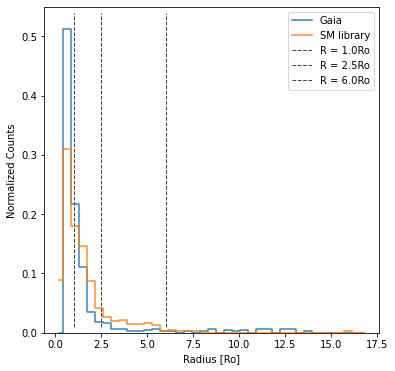

In [125]:
plt.figure(figsize = [6,6])
bins = np.linspace(0,17,40)
values, bins = np.histogram(gaia_data['radius_val'].to_numpy(), bins = bins)
bincenters= [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
plt.step(bincenters,values/len(gaia_data['radius_val'].to_numpy()),where='mid', label = 'Gaia', alpha = 0.9)
values, bin_edges = np.histogram(yee_data['R* [Rsun]'], bins = bins)
bincenters= [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
plt.step(bincenters,values/len(yee_data['R* [Rsun]']),where='mid', label = 'SM library', alpha = 0.9)
plt.vlines([1], ymin = 0.01, ymax = 0.54, label = 'R = 1.0Ro', lw = 1, alpha = 0.75, ls = 'dashed')
plt.vlines([2.5], ymin = 0.01, ymax = 0.54, label = 'R = 2.5Ro', lw = 1, alpha = 0.75, ls = 'dashed')
plt.vlines([6], ymin = 0.01, ymax = 0.54, label = 'R = 6.0Ro', lw = 1, alpha = 0.75, ls = 'dashed')
plt.ylabel('Normalized Counts')
plt.xlabel('Radius [Ro]')
plt.legend()
plt.ylim([0,0.55])


(array([ 61., 113.,  69.,  48.,  33.,  19.,  11.,   6.,   6.,   9.,   5.,
          5.,   8.,   4.,   1.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.168   ,  0.558325,  0.94865 ,  1.338975,  1.7293  ,  2.119625,
         2.50995 ,  2.900275,  3.2906  ,  3.680925,  4.07125 ,  4.461575,
         4.8519  ,  5.242225,  5.63255 ,  6.022875,  6.4132  ,  6.803525,
         7.19385 ,  7.584175,  7.9745  ,  8.364825,  8.75515 ,  9.145475,
         9.5358  ,  9.926125, 10.31645 , 10.706775, 11.0971  , 11.487425,
        11.87775 , 12.268075, 12.6584  , 13.048725, 13.43905 , 13.829375,
        14.2197  , 14.610025, 15.00035 , 15.390675, 15.781   ]),
 <a list of 40 Patch objects>)

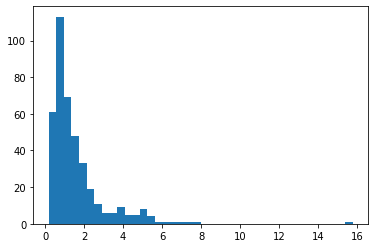

In [93]:
plt.hist(yee_data['R* [Rsun]'], bins = 40)